# Mapping Agricultural-Driven Deforestation in Central Kalimantan with Remote Sensing

Lu Yii Wong 

May 2025

## Part 1: Setup and Data Aquisition 

In [1]:
# Setup Libraries
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import geopandas as gpd
from datetime import datetime

In [16]:
# Authenticate GEE
ee.Authenticate()
ee.Initialize(project='ee-wongluyii')

In [3]:
# Pull Sentinel-2 Imagary using GEE

# Load Boundary for Area of Interest (Pulang Pisau)
gdf = gpd.read_file("data/Pulang_Pisau_boundary.geojson").to_crs(epsg=4326)
roi = geemap.geopandas_to_ee(gdf)

# Load Sentinel-2 SF Image (2A)
sentinel2 = (ee.ImageCollection("COPERNICUS/S2_SR")
             .filterDate("2018-12-01", "2019-12-31")
             .filterBounds(roi)
             .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 30)))  # Optional: <30% cloud cover

# Function to mask clouds and cirrus using QA60 bitmask
def maskS2clouds(image):
    qa = image.select("QA60")
    cloudBitMask = 1 << 10  # Bit 10: clouds
    cirrusBitMask = 1 << 11 # Bit 11: cirrus
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
           qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000).copyProperties(image, ["system:time_start"])

/opt/anaconda3/envs/musa-650/lib/python3.11/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


In [4]:
# Apply cloud masking 
sentinel2_clean = sentinel2.map(maskS2clouds)

# Select bands 
sentinel2_selected = sentinel2_clean.select(["B8", "B12", "B4", "B11", "B3", "B2", "B5", "B6", "B7", "B8A"])

In [5]:
# Create Visual Parameters and Display map
viz_params = {
    "bands": ["B4", "B3", "B2"],
    "min": 0.0,
    "max": 0.3
}

Map = geemap.Map()
Map.centerObject(roi, 9)
Map.addLayer(sentinel2_selected.median().clip(roi), viz_params, "Sentinel-2 Median (2018-2019)")
#Map.addLayer(roi, {}, "Pulang Pisau Boundary")
Map

Map(center=[-2.7158640396563944, 113.95461205914583], controls=(WidgetControl(options=['position', 'transparen…

## Calculate Normalized Burn Ratio (NBR) 

In [6]:
# Create a function to calculate NBR for each Sentinel-2 image
def calculate_nbr(image):
    # NBR = (NIR - SWIR2) / (NIR + SWIR2)
    nbr = image.normalizedDifference(["B8", "B12"]).rename("NBR")
    return image.addBands(nbr)

# Apply the NBR function across the cleaned Sentinel-2 collection
sentinel2_with_nbr = sentinel2_selected.map(calculate_nbr)

# Only keep the NBR band for easier processing later
nbr_collection = sentinel2_with_nbr.select("NBR")

# Visualize the median NBR across the whole period
Map = geemap.Map()
Map.centerObject(roi, 9)
Map.addLayer(nbr_collection.median().clip(roi), {"min": -0.5, "max": 1, "palette": ["white", "green", "black"]}, "Median NBR (2018-2019)")
Map.addLayer(roi, {}, "Pulang Pisau Boundary")
Map

Map(center=[-2.7158640396563944, 113.95461205914583], controls=(WidgetControl(options=['position', 'transparen…

In [7]:
# Check number of images in the filtered Sentinel-2 ImageCollection
n_images = nbr_collection.size().getInfo()
print(f"Number of Sentinel-2 images with NBR in the collection: {n_images}")

# Get list of image dates
timestamps = nbr_collection.aggregate_array("system:time_start").getInfo()
dates = [datetime.utcfromtimestamp(t / 1000).strftime('%Y-%m-%d') for t in timestamps]

# Create a DataFrame
dates_df = pd.DataFrame(dates, columns=["Acquisition Date"])
dates_df.index += 1
print(dates_df)

Number of Sentinel-2 images with NBR in the collection: 234
    Acquisition Date
1         2018-12-30
2         2018-12-30
3         2018-12-30
4         2019-02-08
5         2019-02-08
..               ...
230       2019-12-05
231       2019-12-05
232       2019-12-20
233       2019-12-20
234       2019-12-27

[234 rows x 1 columns]


In [8]:
# Count number of unique acquisition dates
unique_dates = dates_df["Acquisition Date"].nunique()
print(f"Number of unique dates: {unique_dates}")

# Print sorted unique dates
unique_dates_list = sorted(dates_df["Acquisition Date"].unique())

for date in unique_dates_list:
    print(date)

Number of unique dates: 64
2018-12-30
2019-02-08
2019-02-15
2019-02-20
2019-02-23
2019-02-25
2019-03-15
2019-03-17
2019-03-20
2019-03-22
2019-04-01
2019-04-06
2019-04-21
2019-04-26
2019-05-01
2019-05-04
2019-05-06
2019-05-09
2019-05-16
2019-05-24
2019-06-05
2019-06-23
2019-06-28
2019-06-30
2019-07-05
2019-07-08
2019-07-13
2019-07-15
2019-07-23
2019-07-25
2019-07-28
2019-07-30
2019-08-02
2019-08-04
2019-08-09
2019-08-12
2019-08-14
2019-08-17
2019-08-19
2019-08-22
2019-08-29
2019-09-01
2019-09-06
2019-09-08
2019-09-11
2019-09-13
2019-09-18
2019-09-23
2019-09-28
2019-10-08
2019-10-13
2019-10-23
2019-10-28
2019-11-05
2019-11-07
2019-11-10
2019-11-15
2019-11-17
2019-11-22
2019-11-25
2019-11-27
2019-12-05
2019-12-20
2019-12-27


## Pre- and Post-Seaonal Fire Composites
The initial method using the moving window does not fit with the data that I have for Pulang Pisau. 

In [9]:
# Pre-Fire Composite (before dry season fires)
pre_fire = (sentinel2_selected
            .filterDate("2019-01-01", "2019-06-30")
            .median()
            .clip(roi))

# Post-Fire Composite (after fire season)
post_fire = (sentinel2_selected
             .filterDate("2019-09-01", "2019-12-31")
             .median()
             .clip(roi))

# Calculate NBR for Pre- and Post-Fire Composites
pre_fire_nbr = pre_fire.normalizedDifference(["B8", "B12"]).rename("NBR")
post_fire_nbr = post_fire.normalizedDifference(["B8", "B12"]).rename("NBR")

# Calculate dNBR
dnbr_simple = pre_fire_nbr.subtract(post_fire_nbr).rename("dNBR")

# Burn mask (Only show areas with dNBR > 0.2)
burn_mask = dnbr_simple.gt(0.2)

# Visualization
Map = geemap.Map()
Map.centerObject(roi, 9)
Map.addLayer(dnbr_simple, {"min": 0, "max": 0.5, "palette": ["white", "yellow", "red", "black"]}, "Simple dNBR (Pre vs Post)")
Map.addLayer(
    dnbr_simple.updateMask(burn_mask),
    {"min": 0.2, "max": 0.5, "palette": ["yellow", "red", "black"]},
    "Burned Areas Mask (dNBR > 0.2)"
)
#Map.addLayer(roi, {}, "Pulang Pisau Boundary")
Map


Map(center=[-2.7158640396563944, 113.95461205914583], controls=(WidgetControl(options=['position', 'transparen…

In [10]:
# Burn mask (Only show areas with dNBR > 0.2)
burn_mask = dnbr_simple.gt(0.2)

# Visualization
Map = geemap.Map()
Map.centerObject(roi, 9)
Map.addLayer(roi, {}, "Pulang Pisau Boundary")
Map.addLayer(
    dnbr_simple.updateMask(burn_mask),
    {"min": 0.2, "max": 0.5, "palette": ["yellow", "red", "black"]},
    "Burned Areas Mask (dNBR > 0.2)"
)
Map

Map(center=[-2.7158640396563944, 113.95461205914583], controls=(WidgetControl(options=['position', 'transparen…

In [11]:
# Export Burn Mask
# Vectorize the burn_mask
burn_mask_binary = dnbr_simple.gt(0.2)  

# Convert raster burn mask to polygons
burned_vectors = burn_mask_binary.selfMask().reduceToVectors(
    geometry=roi.geometry(),        # only vectorize within ROI
    scale=30,                       # match Sentinel-2 resolution
    geometryType='polygon',
    labelProperty='burned',          # property name in output
    reducer=ee.Reducer.countEvery(), # simplest reducer
    maxPixels=1e13
)

# Export as Shapefile (to Google Drive)
task = ee.batch.Export.table.toDrive(
    collection=burned_vectors,
    description='Export_Burned_Areas',
    folder='earthengine',      
    fileNamePrefix='burned_areas_pulangpisau',
    fileFormat='SHP'
)

task.start()


In [12]:
# Export Post-season Sentinel-2 Composite to Google Drive
export = ee.batch.Export.image.toDrive(
    image=post_fire,
    description="Post_Fire_Composite_2019",
    folder="kalimantan-post-fire",  
    fileNamePrefix="post_fire_2019",
    region=roi.geometry(),
    scale=10,
    maxPixels=1e13
)

export.start()


In [13]:
# # Add in spectral indices 
# # Function to add burn-relevant spectral indices
# def addBurnIndices(image):
#     nbr = image.normalizedDifference(['B8', 'B12']).rename('NBR')
#     ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
#     ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
#     return image.addBands([nbr, ndvi, ndmi])

# # Apply to your post-fire composite
# post_fire_with_indices = addBurnIndices(post_fire)

# # Select specific bands + indices in your preferred order
# selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NBR', 'NDVI', 'NDMI']
# post_fire_final = post_fire_with_indices.select(selected_bands)


In [15]:
# export = ee.batch.Export.image.toDrive(
#     image=post_fire_final,
#     description='PostFire_Composite_with_Indices',
#     folder='kalimantan-spectral',  # Change this to your desired Google Drive folder
#     fileNamePrefix='post_fire_2019_indices',
#     region=roi.geometry(),
#     scale=10,
#     maxPixels=1e13
# )

# export.start()


# Train Random Forest Model

## Bring in Labled training points 
There's a total of 545 labled points, with 210 burn points and 335 not burn points.

In [7]:
import geemap

# Load training samples shapefile 
samples = geemap.shp_to_ee("data/kalimantan-class/kalimantan_burn.shp")

print(samples.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [113.7721283510001, -3.2306885509999574]}, 'id': '0', 'properties': {'Class': 'burn'}}


In [8]:
# Filter by class values
burned = samples.filter(ee.Filter.eq("Class", "burn"))
not_burned = samples.filter(ee.Filter.eq("Class", "not burn"))

# Merge into one collection
sample = burned.merge(not_burned)

# Create label dictionary
label_map = ee.Dictionary({
    "not burn": 0,
    "burn": 1
})

# Function to assign numeric labels
def add_label(feature):
    return feature.set("label", label_map.get(feature.get("Class")))

# Apply the function
sample = sample.map(add_label)

# Check feature properties
print(sample.first().propertyNames().getInfo())

['label', 'system:index', 'Class']


## Mosaic Sentinel-2 Image

In [18]:
# Mosaic Sentinel-2 Images
# Load libraries
import rasterio
from rasterio.merge import merge
from pathlib import Path

# Folder with .tif files
folder = Path("data/kalimantan-post-fire-images")
tif_files = list(folder.glob("*.tif"))

# Open all rasters
src_files_to_mosaic = [rasterio.open(str(fp)) for fp in tif_files]

# Merge and keep transform/meta
mosaic, out_transform = merge(src_files_to_mosaic)

# Use metadata from first file, but update dimensions
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
})

# Output file path
output_path = "data/post-fire-mosaic.tif"

with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(mosaic)


In [9]:
import numpy as np

# Open mosaic
raster_path = "data/post-fire-mosaic.tif"
with rasterio.open(raster_path) as src:
    img = src.read()  # shape: (bands, rows, cols)
    profile = src.profile

# Map band names to array indexes
band_names = ['B8', 'B12', 'B4', 'B11', 'B3', 'B2', 'B5', 'B6', 'B7', 'B8A']
band_dict = {name: img[i] for i, name in enumerate(band_names)}


Here, I select relevant bands for the analysis.
1. B2-B4: Visible spectrum, important for color information and distinguishing surface material
2. B8: NIR, sensitive to vegetation density and heavily drops after fire
3. B11-B12: SWIR, highly responsive to char, ash, and moisture loss, which shows burn severity

The other bands like B5-B7 and B8A were not included to reduce colinearity in the analysis as they add redundant information, given that NIR and SWIR are already included. Moreover, these layers have lower spatial resoltion (20m) which is a mismatch to the 10m bands and would require additional resampling. 

For this analysis, I am prioritizing burn classification, so the 6 raw bands and NDVI and NBR indecies offer **high signal strength** for fire detection and **low dimensionality** to avoid overfitting in the model.

In [10]:
# Compute NDCI and NBR
# NDVI = (B8 - B4) / (B8 + B4)
ndvi = (band_dict['B8'] - band_dict['B4']) / (band_dict['B8'] + band_dict['B4'] + 1e-10)

# NBR = (B8 - B12) / (B8 + B12)
nbr = (band_dict['B8'] - band_dict['B12']) / (band_dict['B8'] + band_dict['B12'] + 1e-10)

In [11]:
# Stack selected bands and indices
selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']  # 6 raw bands
stacked = np.stack([band_dict[b] for b in selected_bands] + [ndvi, nbr])  # shape: (bands, rows, cols)

In [12]:
# Save new raster
profile.update(count=stacked.shape[0], dtype='float32')

with rasterio.open("data/post_fire_with_indices.tif", "w", **profile) as dst:
    dst.write(stacked.astype("float32"))

## Combine Labels and Image

In [21]:
# # Export your sample FeatureCollection with labels
# task = ee.batch.Export.table.toDrive(
#     collection=sample.select(['label']),
#     description='burn_training_samples_export',
#     fileFormat='GeoJSON',
#     folder='kalimantan-burn-samples'  # this will go to a folder in your Google Drive
# )

# task.start()

In [23]:
import geopandas as gpd
import rasterio
import pandas as pd
import numpy as np

# Load training points
gdf = gpd.read_file("data/burn_training_samples.geojson")

# Load the raster
raster_path = "data/post_fire_with_indices.tif"
with rasterio.open(raster_path) as src:
    # Convert geometries to coordinate tuples
    coords = [(geom.x, geom.y) for geom in gdf.geometry]

    # Sample the raster at these coordinates
    pixel_vals = list(src.sample(coords)) 


In [24]:
# Define band names in the order used during stacking
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR']

# Convert sampled values to a DataFrame
X = pd.DataFrame(pixel_vals, columns=bands)

# Add the burn/not burn label
X['label'] = gdf['label']

In [25]:
# Check that DF combined correctly
print(X.head())       # View the first few rows
print(X.shape)        # Check number of rows and columns
print(X.columns)      # Make sure all expected columns are there

        B2       B3       B4       B8      B11      B12      NDVI       NBR  \
0  0.05485  0.05765  0.06585  0.09975  0.20840  0.18995  0.204710 -0.311357   
1  0.05510  0.05785  0.06025  0.11250  0.20915  0.17155  0.302460 -0.207886   
2  0.06010  0.05890  0.05950  0.12660  0.24470  0.17650  0.360559 -0.164632   
3  0.04750  0.05315  0.04950  0.10960  0.23125  0.15455  0.377750 -0.170168   
4  0.07365  0.06890  0.07165  0.11650  0.23870  0.19230  0.238374 -0.245466   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  
(545, 9)
Index(['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR', 'label'], dtype='object')


In [27]:
print(X['label'].value_counts())


label
0    335
1    210
Name: count, dtype: int64


## Train/Test Split

In [28]:
from sklearn.model_selection import train_test_split

# Separate features and labels
features = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR']
X_features = X[features]
y_labels = X['label']

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)


## Train Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Initialize classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on training data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate Model Performance

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[65  2]
 [ 1 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        67
           1       0.95      0.98      0.96        42

    accuracy                           0.97       109
   macro avg       0.97      0.97      0.97       109
weighted avg       0.97      0.97      0.97       109



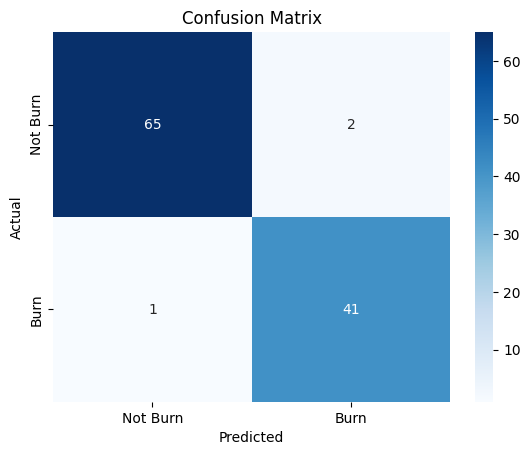

In [31]:
# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Create a labeled confusion matrix
labels = ['Not Burn', 'Burn']
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/var/folders/hv/13df42ds78l435f3912yyj5c0000gn/T/ipykernel_10823/4175700909.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


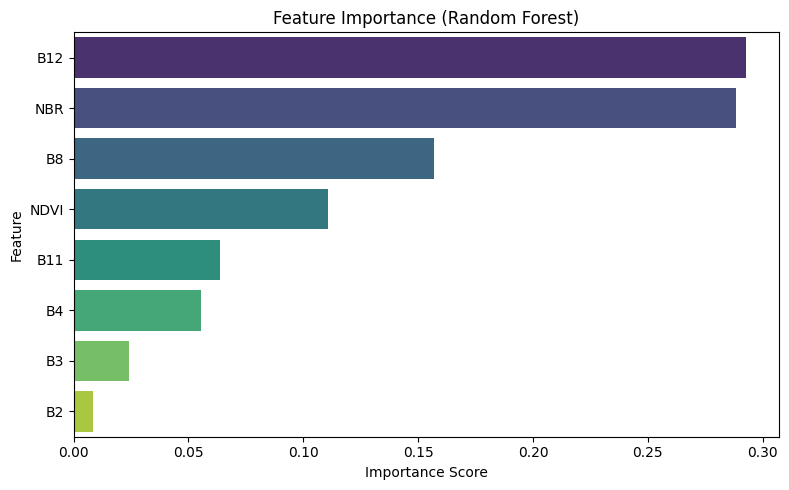

In [32]:
# Get feature importance scores
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Misclassified Points

In [33]:
# Identify misclassified points
misclassified_mask = y_test != y_pred
misclassified_indices = y_test[misclassified_mask].index
print(f"Misclassified sample count: {len(misclassified_indices)}")


Misclassified sample count: 3


In [34]:
# Recover the geometries of misclassified points
misclassified_points = gdf.loc[misclassified_indices]
print(misclassified_points)


        id  label                    geometry
445  2_445      0  POINT (113.95834 -1.56597)
151  1_151      1  POINT (114.20176 -2.35124)
230  2_230      0  POINT (113.89719 -3.04127)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00645..1.1824].


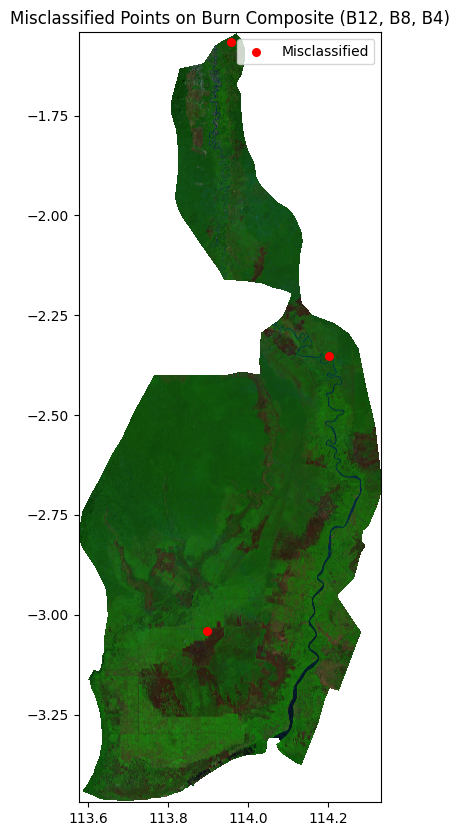

In [36]:
import matplotlib.pyplot as plt
import rasterio.plot

# Burn composite: R=B12, G=B8, B=B4 → bands 6, 4, 3
with rasterio.open("data/post_fire_with_indices.tif") as src:
    rgb = src.read([6, 4, 3])  # 1-based index for rasterio
    fig, ax = plt.subplots(figsize=(10, 10))
    
    rasterio.plot.show(rgb, ax=ax, transform=src.transform)
    
    # Plot misclassified points
    misclassified_points.plot(ax=ax, color='red', markersize=30, label='Misclassified')
    plt.legend()
    plt.title("Misclassified Points on Burn Composite (B12, B8, B4)")
    plt.show()


Next steps would be to apply the rf model onto the sentinel composite to get the total predicted burn area in Pulang Pisau. However, given computing limitations, I was not able to run this.